In [31]:
import json
import re
import sys
from pathlib import Path

import pandas as pd
import numpy as np
from tqdm import tqdm 

import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [2]:
def load_json(path):
    with open(path) as infile:
        return json.load(infile)

def save_json(obj, path):
    with open(path, 'w') as outfile:
        return json.dump(obj, outfile, indent=2)

In [87]:
DATA_DIR = "../data/human/all_data"
DATA_FILE = "all_data.csv"
FILTER_ON_FAMILIARITY = False
DROP_NA = False # if true, then nan/inf set to 0
AVERAGE_ANNOTATIONS = False # average over human annotators before running regression
ITERS = 1_000

## Data compilation

In [88]:
auto_metric_names = [
 'c_npmi_10_full',
 'c_npmi_10_nytimes_full',
 'c_npmi_10_test',
 'c_npmi_10_train',
 'c_npmi_10_val',
 'c_npmi_10_wikitext_full',
 'c_uci_full',
 'c_v_full',
 'c_v_nytimes_full',
 'c_v_test',
 'c_v_train',
 'c_v_val',
 'c_v_wikitext_full',
 'u_mass_full'
]

In [89]:
task_data = pd.read_csv(Path(DATA_DIR, DATA_FILE))

In [90]:
# complete the out-of-sample columns
for dataset in ["wikitext", "nytimes"]:
    for metric in ["c_npmi_10", "c_v"]:
        task_data[f"{metric}_{dataset}_full"] = task_data[f"{metric}_{dataset}_full"].combine_first(task_data[f"{metric}_full"])

In [91]:
# add the constant for lin. reg
task_data = sm.add_constant(task_data)

In [92]:
# convert infinite values to nans
task_data = task_data.replace(np.inf, np.nan)

In [93]:
if FILTER_ON_FAMILIARITY:
    task_data = task_data.loc[task_data.confidences_raw == 1]

## Rough boxplot

In [63]:
from plotnine import ggplot, aes
from plotnine.geoms import geom_boxplot
from plotnine.scales import scale_x_discrete
from plotnine.facets import facet_grid, facet_wrap

In [72]:
task_averages = task_data.groupby(['task', 'dataset', 'model', 'topic_idx'])[["scores_raw"]].mean().reset_index()

/workspace/.conda/envs/statsmodels-dev/lib/python3.8/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


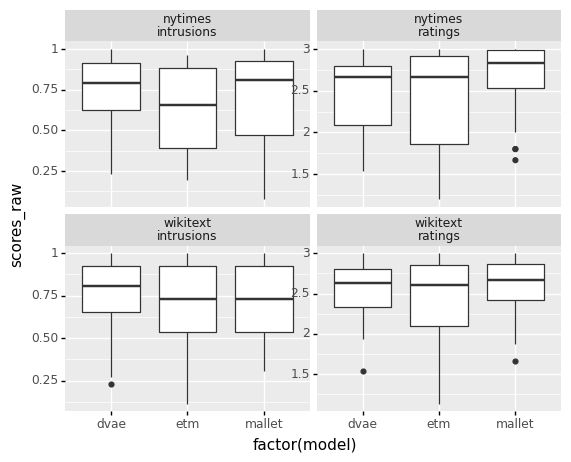

<ggplot: (8735567215529)>

In [74]:
(
    ggplot(task_averages)
    + geom_boxplot(aes(x="factor(model)", y="scores_raw"))
    + facet_wrap("~dataset+task", scales="free_y")
)

## Regression 

Assess variances by topic. This may help determine if averaging is ok

/workspace/.conda/envs/topic-preprocessing/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([<AxesSubplot:title={'center':'intrusions'}>,
       <AxesSubplot:title={'center':'ratings'}>], dtype=object)

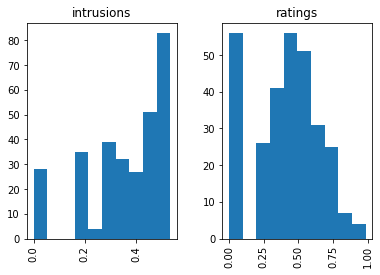

In [13]:
topic_stds = task_data.groupby(['task', 'dataset', 'model', 'topic_idx']).agg({"scores_raw": "std"}).reset_index()
topic_stds["scores_raw"].hist(by=topic_stds["task"])

 First, simple linear regression (ignoring model effects)

In [13]:
task_data.columns

Index(['const', 'dataset', 'model', 'topic_idx', 'human_idx', 'c_npmi_10_full',
       'c_npmi_10_nytimes_full', 'c_npmi_10_test', 'c_npmi_10_train',
       'c_npmi_10_val', 'c_uci_full', 'c_v_full', 'c_v_nytimes_full',
       'c_v_test', 'c_v_train', 'c_v_val', 'u_mass_full', 'scores_raw',
       'confidences_raw', 'c_npmi_10_wikitext_full', 'c_v_wikitext_full',
       'task'],
      dtype='object')

In [35]:
re.search("c_v|c_npmi_10", "c_npmi_10_14").group(0)

'c_npmi_10'

In [47]:
AVERAGE_ANNOTATIONS = False
FILTER_ON_FAMILIARITY = False
DROP_NA = False
ALPHA = 0.05

rows = []
for task in ["ratings", "intrusions"]:
    for dataset in ["wikitext", "nytimes", "all"]:
        data_df = task_data.loc[task_data.task == task]
        if dataset != "all":
            data_df = data_df.loc[data_df.dataset == dataset]
        if FILTER_ON_FAMILIARITY:
            data_df = data_df.loc[data_df.confidences_raw == 1]

        # select best metric based on BIC
        for i, metric in enumerate(auto_metric_names):
            #print(f"\n===={task}, {dataset}, {metric}====\n")
            if dataset in metric:
                continue # don't re-do the internal
            if DROP_NA:
                df = data_df.dropna(subset=[metric])
            else:
                df = data_df.fillna(0)

            if AVERAGE_ANNOTATIONS:
                df = df.groupby(["model", "topic_idx"]).mean().reset_index()
                mod = sm.OLS(df["scores_raw"], df[["const", metric]])
            elif task == "intrusions":
                mod = sm.Logit(df["scores_raw"], df[["const", metric]])
            elif task == "ratings":
                mod = OrderedModel(df["scores_raw"], df[[metric]], distr="probit")
            res = mod.fit(disp=0)
            metric_base = re.search("c_npmi_10|c_v|c_uci|u_mass", metric).group(0)
            ci_lb, ci_ub = res.conf_int(alpha=ALPHA).loc[metric] 
            row = {
                "task": task,
                "dataset": dataset,
                "metric": metric_base,
                "reference": metric.replace(f"{metric_base}_", ""),
                "coef": res.params[metric],
                "se": res.bse[metric],
                "p": res.pvalues[metric],
                "bic": res.bic,
                "ci_0.025": ci_lb,
                "ci_0.975": ci_ub,
            }
            rows.append(row)
regressions = pd.DataFrame(rows)

Make the latex table

In [59]:
METRICS_TO_KEEP = ["c_v", "c_npmi_10"]
regressions_pivot = (
    regressions.loc[regressions.metric.isin(METRICS_TO_KEEP)]
               .replace(
                   to_replace={
                       "c_v": r"$C_v$",
                       "c_npmi_10": r"\abr{npmi}",
                       "wikitext": r"\abr{wiki}",
                       "nytimes": r"\abr{nyt}",
                       "all": "Both",
                       "full": "Full",
                       "train": "Train",
                       "val": "Val",
                       "test": "Test",
                       "nytimes_full": r"\abr{nyt}",
                       "wikitext_full": r"\abr{wiki}",
                       "ratings": "Rating",
                       "intrusions": "Intrusion",
                   },
               )
               #.pivot(index=["metric", "reference"], columns=["task", "dataset"], values="coef")
               .pivot(index=["task", "dataset"], columns=["metric", "reference"], values="coef")
)
regressions_pivot

metric               \abr{npmi}                                          \
reference                  Full \abr{nyt}      Test     Train       Val   
task      dataset                                                         
Intrusion Both         3.302310  2.818381  3.399193  3.183025  0.782898   
          \abr{nyt}    2.422046       NaN  2.417874  2.113956  1.965700   
          \abr{wiki}   5.080955  4.113136  5.587212  5.450007  0.866032   
Rating    Both         2.603440  2.198101  2.710738  2.519791  1.172331   
          \abr{nyt}    1.923581       NaN  1.923726  1.768815  1.853523   
          \abr{wiki}   4.102791  2.974933  4.684632  4.294215  1.446807   

metric                   $C_v$                                          \
reference                 Full \abr{nyt}      Test     Train       Val   
task      dataset                                                        
Intrusion Both        2.631910  2.295045  2.668434  2.642521  0.868194   
          \abr{nyt}   2.503865       NaN  2.498807  2.548619  2.404437   
          \abr{wiki}  2.788559  2.229189  2.900447  2.740753  0.699336   
Rating    Both        2.670262  2.267314  2.719647  2.741120  1.072490   
          \abr{nyt}   2.553519       NaN  2.550554  2.676623  2.592513   
          \abr{wiki}  2.819569  2.007220  2.949492  2.857542  0.799491   

metric               \abr{npmi}      $C_v$  
reference            \abr{wiki} \abr{wiki}  
task      dataset                           
Intrusion Both         4.563023   3.053492  
          \abr{nyt}    4.161371   3.269945  
          \abr{wiki}        NaN        NaN  
Rating    Both         2.750119   2.597973  
          \abr{nyt}    2.079813   2.511638  
          \abr{wiki}        NaN        NaN

```ratings wikitext: c_v_train, 2.8575
ratings nytimes: c_v_train, 2.6766
ratings all: c_v_train, 2.7411
intrusions wikitext: c_npmi_10_train, 5.4500
intrusions nytimes: c_v_wikitext_full, 3.2699
intrusions all: c_v_wikitext_full, 3.0535

In [44]:
b

0.02788763431941472

In [17]:
task_data.task.unique()

array(['ratings', 'intrusions'], dtype=object)

In [43]:
res.bic, res.rsquared_adj, res.

4219.420408881373

Linear regression with model effects

Linear regression with familiarity effect

Best explanation of data